## Create and test ion channel model

In [1]:
from channels.cm_ina_markov import (protocols,
                                    observations,
                                    simulations,
                                    times,
                                    summary_statistics)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
from functools import wraps

def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','ina.i_Na','ina.g','ina.m','ina.h','ina.j']))
        except:
            # Failed simulation
            del(data)
            return None
    return data

def log_transform(f):
    @wraps(f)
    def log_transformed(**log_kwargs):
        kwargs = dict([(key[4:], 10**value) if key.startswith("log")
                       else (key, value)
                       for key, value in log_kwargs.items()])
        return f(**kwargs)
    return log_transformed

def log_model(x):
    return log_transform(simulate_model)(**x)

In [3]:
test = simulate_model()

In [4]:
ss = summary_statistics(test)

In [5]:
assert(len(ss)==len(observations))

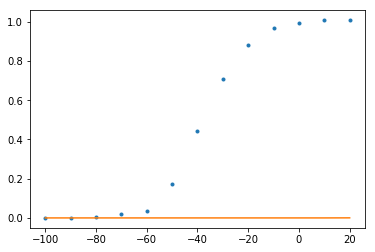

In [6]:
import matplotlib.pyplot as plt
key = observations.exp_id=='0'
plt.plot(observations[key].x, observations[key].y, '.')
plt.plot(observations[key].x, list(ss.values())[:13])

## Set limits and generate uniform initial priors

In [7]:
from pyabc import Distribution, RV
limits = {#'ina.g_Na': (0, 100.),
          'log_ina.p_1': (-50.0, 50.0),#(-50, 50),
          'ina.p_2': (0, 1.),
          'log_ina.p_3': (-50.0, 50.0),#(-50, 50),
          'ina.p_4': (0, 1.),
          'log_ina.p_5': (-50.0, 50.0),#(-50, 50),
          'ina.p_6': (0, 1.),
          'log_ina.p_7': (-50.0, 50.0),#(-50, 50),
          'ina.p_8': (0, 1.),
          'log_ina.p_9': (-50.0, 50.0),#(-50, 50),
          'ina.p_10': (0, 1.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [8]:
print(prior.rvs())
test = log_model(prior.rvs())

<Parameter 'log_ina.p_1': 22.761503774067805, 'ina.p_2': 0.7901714509010273, 'log_ina.p_3': 19.066605465207658, 'ina.p_4': 0.7242361947725489, 'log_ina.p_5': -8.358887457751663, 'ina.p_6': 0.4941078834614596, 'log_ina.p_7': 29.191320986994214, 'ina.p_8': 0.5842053964664988, 'log_ina.p_9': -30.772492542088635, 'ina.p_10': 0.1736461914061942>


## Run ABC calibration

In [20]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "cm_ina_markov.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/cm_ina_markov.db


In [21]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [22]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [23]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=log_model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.01),
             population_size=ConstantPopulationSize(500),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=10000,
             #    mean_cv=0.4,
             #    max_population_size=30000,
             #    min_population_size=pop_size),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 2.0095229310121105, '1': 2.0095229310121105, '2': 2.0095229310121105, '3': 2.0095229310121105, '4': 2.0095229310121105, '5': 0.1527257690136845, '6': 0.12501603033187678, '7': 0.17741795921350126, '8': 0.2370303935092392, '9': 2.0095229310121105, '10': 2.0095229310121105, '11': 2.0095229310121105, '12': 2.0095229310121105, '13': 2.1769831752631195, '14': 2.1769831752631195, '15': 2.1769831752631195, '16': 2.1769831752631195, '17': 2.1769831752631195, '18': 0.1604893289385467, '19': 0.1045533087547536, '20': 0.12021672579666429, '21': 0.2006116611731835, '22': 2.1769831752631195, '23': 2.1769831752631195, '24': 0.03204969054205446, '25': 0.037135303942605995, '26': 0.0381335648012782, '27': 0.05183078116328874, '28': 0.089782823456174, '29': 0.11701390823539425, '30': 0.23051739922372666, '31': 0.08585377997159281, '32': 0.24137947562693893, '33': 0.144364297737393, '34': 0.28421721117049237, '35': 0.39543264162851127, '36': 0.6496393398182684}
DEBUG

In [24]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [25]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-06-19 10:20:59.428907, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.0005)

INFO:ABC:t:13 eps:0.44135268837329983
DEBUG:ABC:now submitting population 13


# Results analysis

In [39]:
from pyabc import History

In [40]:
history = History('sqlite:////scratch/cph211/tmp/cm_ina_markov.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-06-18 14:52:12.431003, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-06-18 20:11:26.143916, end_time=None)>,
 <ABCSMC(id=3, start_time=2019-06-18 20:29:22.954218, end_time=None)>,
 <ABCSMC(id=4, start_time=2019-06-19 10:20:59.428907, end_time=None)>]

In [41]:
history.id = 4

In [42]:
df, w = history.get_distribution(m=0)

In [43]:
df.describe()

name,ina.p_10,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7,log_ina.p_9
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.234543,0.580603,0.149714,0.150549,0.785988,5.844314,-19.570967,1.840747,-38.700636,-3.847253
std,0.123124,0.022936,0.121581,0.000586,0.115256,0.337998,11.284534,0.019558,5.592177,3.344872
min,0.001285,0.540763,0.000417,0.148875,0.240704,5.234091,-49.697403,1.785873,-49.931097,-19.992979
25%,0.130880,0.561588,0.058787,0.150135,0.715342,5.566133,-27.394076,1.826253,-42.825175,-5.416068
50%,0.217935,0.575712,0.120709,0.150604,0.795804,5.766112,-17.150048,1.843478,-39.170814,-2.204654
75%,0.349304,0.595024,0.209796,0.151033,0.866445,6.017480,-10.420750,1.856493,-35.373643,-1.456597
max,0.518713,0.650705,0.735483,0.151886,0.997244,6.874009,-4.118804,1.885023,-13.010025,0.555659


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make ax

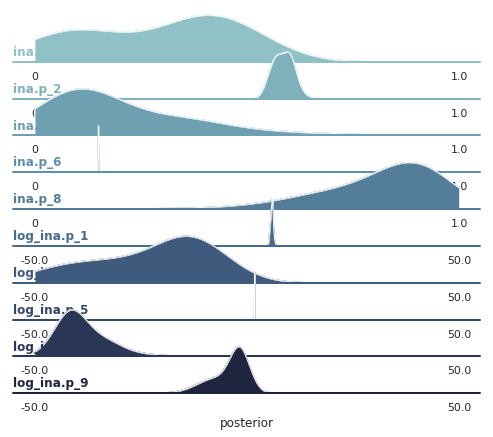

In [44]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [45]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [46]:
plotting_obs = observations.copy()

In [47]:
plotting_obs.rename({'exp_id': 'exp', 'variance': 'errs'}, axis=1, inplace=True)

In [48]:
import numpy as np
plotting_obs['errs'] = np.sqrt(plotting_obs['errs'])

In [49]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(log_model(th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp': plotting_obs.exp})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

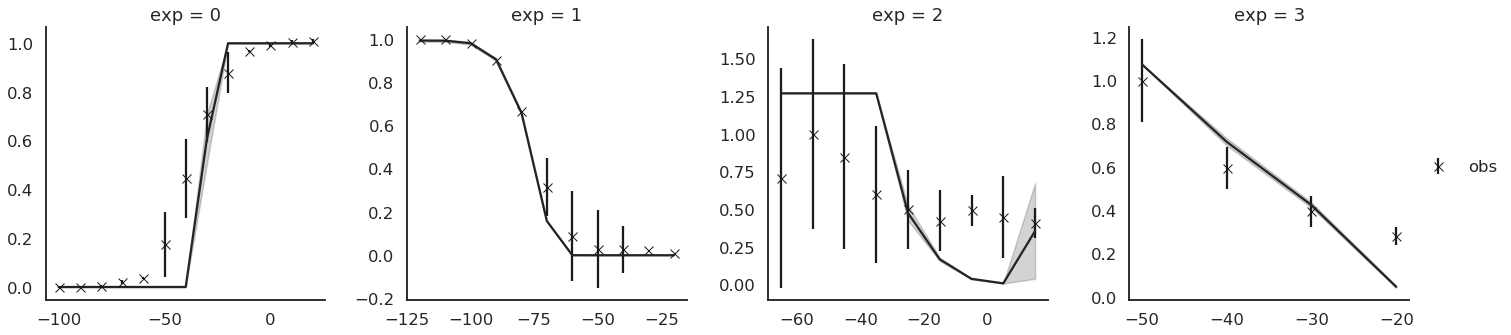

In [50]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=plotting_obs)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [51]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

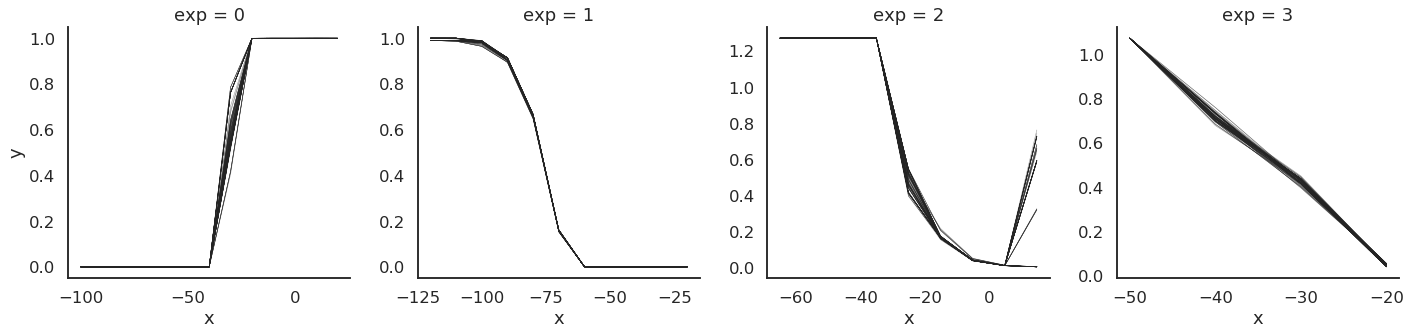

In [52]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
